### Notebook used to to measure collimation of the telescope using ATCollCam using the CWFS algorithm/package developed by Bo Xin.

#### Now using fork by David Thomas: https://github.com/davidthomas5412/cwfs 

#### This requires that the parameter file for the CWFS algorithm be placed in the cwfs directory structure. 

In [1]:
import numpy as np
#from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
from matplotlib import pyplot as plt
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]


import matplotlib.pyplot as plt
%matplotlib inline
import time

import os
import copy
from pathlib import Path

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')


In [2]:
#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

In [3]:
import numpy as np
import logging
logger = logging.getLogger('calc_CofM_logger')

# declare Centroiding algorithm
def calc_CofM(array, offset=(0,0)):
    # Function takes a a 2d Array and computes the CofM
    
    # offset is the coordinate of the minimum y and x pixel
    
    
    #just make it easier to parse the code below
    shape=array.shape
        
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, shape[0], 1)+ offset[0]
    ones_array_2d=np.ones([shape[1], shape[0]])
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # Can't just use the transpose of the y_index_arr_2d
    # since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, shape[1], 1) + offset[1]
    ones_array_2d=np.ones([shape[0], shape[1]])
    # array will be left to right so need to transpose
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d

    # Calculate the centroid
    y_CofM = np.sum(y_index_arr_2d*array)/np.sum(array)
    x_CofM = np.sum(x_index_arr_2d*array)/np.sum(array)
    
    logger.info('y_CofM is {}'.format(y_CofM))
    logger.info('x_CofM is {}'.format(x_CofM))

    return(y_CofM, x_CofM)

In [4]:
# This is just used to test the CofM algorithm.
def make_circle(yxdims, radius, center=None):
    
    #Creates a circle where the internal pixels equal 1 and the rest are zero
    
    #dims is y,x dimensions
    
    # If center isn't declared then put it at the center of the box
    if center==None:
        center=(yxdims[0]/2, yxdims[1]/2)
    
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, yxdims[1] , 1) - center[1]
    ones_array_2d=np.ones((yxdims[0], yxdims[1]))
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d
    
    # Can't just transpose x-indice array since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, yxdims[0], 1) - center[0]
    ones_array_2d=np.ones((yxdims[1],yxdims[0]))
    # array will be left to right so need to transpose
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # creates an array with a given side, and a circle of radius x and position xy
    r_arr= np.sqrt(y_index_arr_2d**2 + x_index_arr_2d**2)
    
    arr=np.zeros((yxdims[0],yxdims[1]) ,dtype=float)
    
    arr[r_arr < radius] = 1
    return(arr)

In [5]:
# Testing the CofM code
if False:
    center=(1400,750)
    stamp=make_circle((2500,1400), 100, center=center)

    calc_CofM(stamp)

    # Now try with subimage and reference to corner
    side=300
    guess_center = np.array((1550, 610))
    stamp2= stamp[guess_center[0]-side:guess_center[0]+side, 
                  guess_center[1]-side:guess_center[1]+side].copy()
    calc_CofM(stamp2, offset=(guess_center-side))

    if False:
        fig, ax = plt.subplots(figsize=(7,6))
        ax.imshow(stamp, interpolation='none')
        stamp.shape

        fig2, ax2 = plt.subplots(figsize=(7,6))
        ax2.imshow(stamp2, interpolation='none')
        stamp2.shape

## Target Coordinates

In [ ]:
# # ra = Angle(“3:19:30.51”, unit=u.hour)
# dec = Angle(“-24:29:22.9", unit=u.deg)
# target_name=“Faint Eri”
# radec = ICRS(ra, dec)

In [9]:
from lsst.ts import salobj
import wget

In [14]:
d = salobj.Domain()
gencam = salobj.Remote(d, 'GenericCamera', index=1)
athexapod = salobj.Remote(d, 'ATHexapod')
await gencam.start_task
await athexapod.start_task

2019-09-27 05:43:39,887 GenericCamera WARNING  RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 92 messages
2019-09-27 05:43:39,893 ATHexapod    INFO     Read historical data in 0.00 sec
2019-09-27 05:43:39,896 GenericCamera INFO     Read historical data in 0.01 sec


In [16]:
gencam.cmd_setLogLevel.set(level=logging.DEBUG)
athexapod.cmd_setLogLevel.set(level=logging.DEBUG)

True

In [17]:
# Get summary state
print(salobj.State(gencam.evt_summaryState.get().summaryState))
print(salobj.State(athexapod.evt_summaryState.get().summaryState))

State.ENABLED
State.ENABLED


In [32]:
# Declare where data is located and where output will be written, notably the stacked images
data_folder = Path("/home/saluser/develop/ts_notebooks/pingraham/summit_notebooks/AT_201909")
output_folder = Path("/home/saluser/data/output")

In [81]:
# Intrafocal hexapod setting
z_cen=0.32
dz=0.5
await athexapod.cmd_moveToPosition.set_start(x=-4., y=1.,z=z_cen-dz, u=0.35, v=0.22)

2019-09-27 06:26:07,662 GenericCamera WARNING  RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 96 messages
2019-09-27 06:26:07,666 GenericCamera WARNING  RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 96 messages
2019-09-27 06:26:07,673 ATHexapod    WARNING  RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 95 messages
2019-09-27 06:26:07,678 ATHexapod    WARNING  RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 95 messages


In [82]:
# r.evt_endReadout.flush()
expTime=4.0
await gencam.cmd_takeImages.set_start(numImages=1, expTime=expTime, shutter=True, imageSequenceName='Eri')

tmp = await gencam.evt_endReadout.next(flush=False, timeout=1)
tmp = gencam.evt_endReadout.get()
print(tmp.imageName)

1325437412-Eri-0-1


In [83]:
wget_url = 'http://192.168.1.216:8000/'+tmp.imageName+'.fits'
#print(wget_url)
intra_fname = wget.download(wget_url)
print('Grabbed/Wrote {} via wget'.format(intra_fname))

Grabbed/Wrote 1325437412-Eri-0-1.fits via wget


In [84]:
# Extrafocal hexapod setting
await athexapod.cmd_moveToPosition.set_start(x=-4., y=1.,z=z_cen+dz, u=0.35, v=0.22)

2019-09-27 06:26:35,361 ATHexapod    WARNING  RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 11 messages
2019-09-27 06:26:35,363 GenericCamera WARNING  RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 10 messages
2019-09-27 06:26:35,364 GenericCamera WARNING  RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 10 messages
2019-09-27 06:26:35,368 ATHexapod    WARNING  RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 10 messages


In [85]:
# r.evt_endReadout.flush()
await gencam.cmd_takeImages.set_start(numImages=1, expTime=expTime, shutter=True, imageSequenceName='Eri')

tmp = await gencam.evt_endReadout.next(flush=False, timeout=1)
tmp = gencam.evt_endReadout.get()
print(tmp.imageName)

1325437435-Eri-0-1


In [86]:
wget_url = 'http://192.168.1.216:8000/'+tmp.imageName+'.fits'
#print(wget_url)
extra_fname = wget.download(wget_url)
print('Grabbed/Wrote {} via wget'.format(extra_fname))

Grabbed/Wrote 1325437435-Eri-0-1.fits via wget


In [87]:
# Declare where data is located and where output will be written, notably the stacked images
data_folder = Path("/home/saluser/develop/ts_notebooks/pingraham/summit_notebooks/AT_201909")
output_folder = Path("/home/saluser/data/output")

### Declare data directories and intra/extra raw file lists

In [88]:
# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(data_folder / intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(data_folder / extra_fname))[0].data

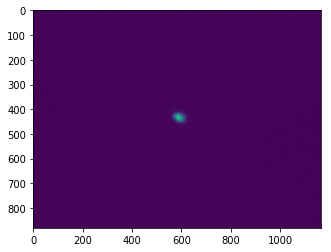

In [89]:
plt.imshow(extra_exp)

In [90]:
im_shape=intra_exp.shape
side=200
ceny=400 #round(im_shape[0]/2)
cenx=600 # round(im_shape[1]/2)
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

In [91]:
#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

## Load instrument profile from "/home/saluser/develop/cwfs/data/auxtel"
### Make sure pixelSize and offset are correct for the dataset! 
### You *must* modify the file and not the loaded object!!!

In [92]:
# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example

Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :20.5 [mm] at the focus
pixelSize should be: 1.44e-05


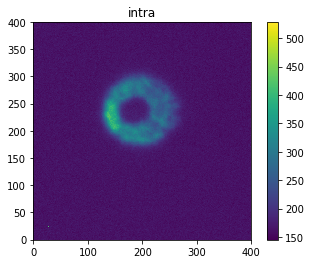

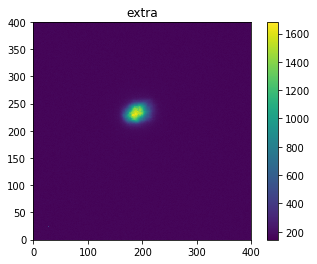

In [93]:
# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')

In [49]:
# Calculate zernikes and wavefront
# Note that this will change I1 and I2!
# if you ever want to rerun this with different parameters you have to reload I1 and I2!
algo.runIt(inst,I1,I2,'onAxis')

In [50]:
#print zernikes
print(algo.zer4UpNm)

[ 3.11409208e+00 -5.28866418e+00  2.36802885e+00  9.50424284e+00
  3.68220583e+01 -7.69254475e+00  1.57470318e+00 -2.18235763e-01
 -2.59300421e-01  1.50855275e-01  6.62425167e-02 -1.01772589e-01
 -2.11369071e+00  2.77050616e+00 -4.31109875e-01  8.64707338e-01
  8.98835890e+00  7.15831118e+00 -3.42397190e-02]


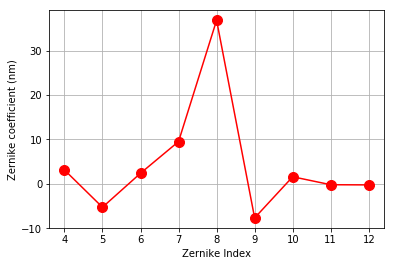

In [51]:
# plot the zernikes
plots.plotZer(algo.zer4UpNm[0:9],'nm')

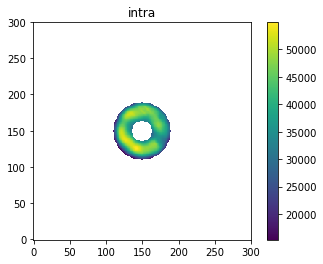

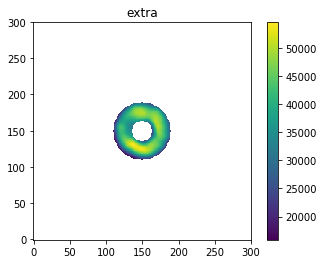

In [34]:
# Plot images with masks to check mapping is correct
# I think these plot residuals, but I1.image0 plots the original image
plots.plotImage(I1.image,'intra', mask=algo.pMask) 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra', mask=algo.pMask)

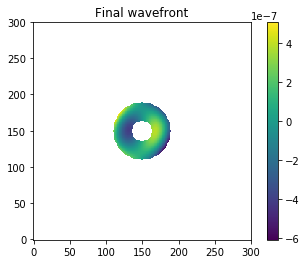

In [57]:
plots.plotImage(algo.Wconverge,'Final wavefront')

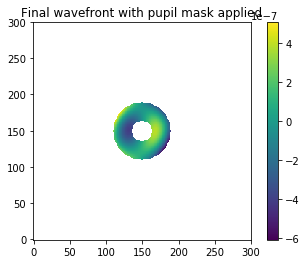

In [58]:
plots.plotImage(algo.Wconverge,'Final wavefront with pupil mask applied', mask=algo.pMask)

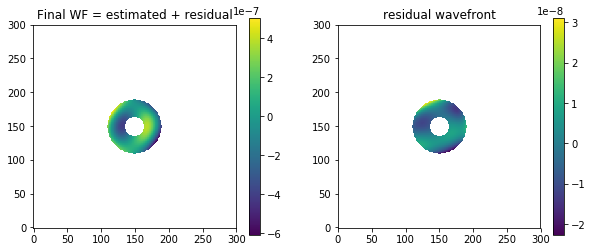

In [59]:
# Look at estimated wavefront and residual of wavefront that is not well fit
nanMask = np.ones(I1.image.shape)
nanMask[I1.pMask==0] = np.nan
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(algo.Wconverge*nanMask, origin='lower')
ax[0].set_title('Final WF = estimated + residual')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(algo.West*nanMask, origin='lower')
ax[1].set_title('residual wavefront')
fig.colorbar(img, ax=ax[1])

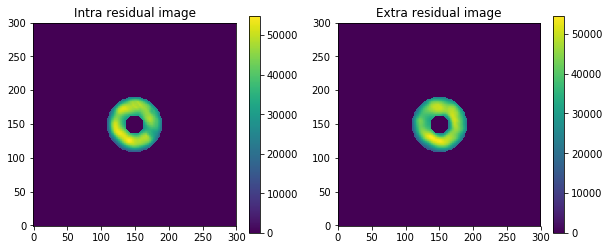

In [60]:
# Plot the residuals at each image - ideally they would be a constant
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(I1.image, origin='lower')
ax[0].set_title('Intra residual image')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(I2.image, origin='lower')
ax[1].set_title('Extra residual image')
fig.colorbar(img, ax=ax[1])

#### Now we do the forward raytrace using our wavefront solutions. The code is simply borrowed from existing cwfs code.

#### We first set up the pupil grid. Oversample means how many ray to trace from each grid point on the pupil.

In [61]:
oversample = 10
projSamples = I1.image0.shape[0]*oversample

luty, lutx = np.mgrid[
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5),
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5)]
lutx = lutx / (projSamples / 2 / inst.sensorFactor)
luty = luty / (projSamples / 2 / inst.sensorFactor)

#### We now trace the rays to the image plane. Lutxp and Lutyp are image coordinates for each (oversampled) ray. showProjection() makes the intensity image. Then, to down sample the image back to original resolution, we want to use the function downResolution() which is defined for the image class.

In [62]:
lutxp, lutyp, J = aperture2image(I1, inst, algo, algo.converge[:,-1], lutx, luty, projSamples, 'paraxial')
show_lutxyp = showProjection(lutxp, lutyp, inst.sensorFactor, projSamples, 1)
I1fit = Image(show_lutxyp, fieldXY, Image.INTRA)
I1fit.downResolution(oversample, I1.image0.shape[0], I1.image0.shape[1])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### Now do the same thing for extra focal image

In [ ]:
luty, lutx = np.mgrid[
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5),
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5)]
lutx = lutx / (projSamples / 2 / inst.sensorFactor)
luty = luty / (projSamples / 2 / inst.sensorFactor)

lutxp, lutyp, J = aperture2image(I2, inst, algo, algo.converge[:,-1], lutx, luty, projSamples, 'paraxial')
show_lutxyp = showProjection(lutxp, lutyp, inst.sensorFactor, projSamples, 1)
I2fit = Image(show_lutxyp, fieldXY, Image.EXTRA)
I2fit.downResolution(oversample, I2.image0.shape[0], I2.image0.shape[1])

In [ ]:
#The atmosphere used here is just a random Gaussian smearing. We do not care much about the size at this point
from scipy.ndimage import gaussian_filter

I1fit.image[np.isnan(I1fit.image)]=0
a = gaussian_filter(I1fit.image, sigma=2)

fig, ax = plt.subplots(1,3, figsize=[15,4])
img = ax[0].imshow(I1fit.image, origin='lower')
ax[0].set_title('Forward prediction (no atm) Intra')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(a, origin='lower')
ax[1].set_title('Forward prediction (w atm) Intra')
fig.colorbar(img, ax=ax[1])

img = ax[2].imshow(I1.image0, origin='lower')
ax[2].set_title('Real Image, Intra')
fig.colorbar(img, ax=ax[2])

In [ ]:
I2fit.image[np.isnan(I2fit.image)]=0
b = gaussian_filter(I2fit.image, sigma=2)

fig, ax = plt.subplots(1,3, figsize=[15,4])
img = ax[0].imshow(I2fit.image, origin='lower')
ax[0].set_title('Forward prediction (no atm) Extra')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(b, origin='lower')
ax[1].set_title('Forward prediction (w atm) Extra')
fig.colorbar(img, ax=ax[1])

img = ax[2].imshow(I2.image0, origin='lower')
ax[2].set_title('Real Image, Extra')
fig.colorbar(img, ax=ax[2])

In [ ]:
# Basic math to estimate the expected result (from lab setup)
D=25e-3; wave=632e-9
f_coll=125e-3; 

f_tel=400e-3 # 400mm nominal
pinhole_diam=10e-6

print('Diffraction Limit (f=125mm, D=25mm, wave=632nm) is: {0:3f} [um]'.format(1e6*wave/D*f_coll))
mag=f_tel/f_coll
print('Magnification is f_tel/f_col {}:'.format(mag))
im_size=1e6*mag*pinhole_diam
print('Expected image diameter for {0:3f} diameter pinhole: {1:3f} [um]'.format(pinhole_diam, im_size))
print('80% EE radius in pixels ~{}'.format(im_size/2/10))